In [1]:
import pandas as pd
import numpy as np

import re
import string
import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from Method import *

# word cloud library
from wordcloud import WordCloud

# Vectorize
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

from sklearn.decomposition import TruncatedSVD


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Table of content
+ EDA
+ Preprocessing
+ Modeling
+ Predict
+ Visualize output

In [2]:
# Read data
data= pd.read_csv("Dataset\Reviews.csv")
data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


# EDA:
+ Word count
+ Sentence count

# Preprocessing
+ Lower, remove punctual
+ Remove Stopwords 
+ Lemmatize

In [3]:
# Clean text
df_sampled = preprocess_data(data)
df = df_sampled[['Text']].iloc[:]
df = df['Text'].apply(lambda x: preprocess_text(x, tokenize=False))
df.head()

0    love anna ginger thin cooky hoping find amazon...
1    dont chocolate bell plantation site four jar c...
2    first coffee tried keurig disappointed flavor ...
3    item shipped unsealed plastic within brown car...
4    cat picky eater sometime found weruvia seemed ...
Name: Text, dtype: object

+ Vectorize

In [4]:
# Vectorize
vect =TfidfVectorizer(max_features=500)
vect_text = vect.fit_transform(df)

# Modeling

In [5]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, end, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, end, step):
        model = gensim.models.LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

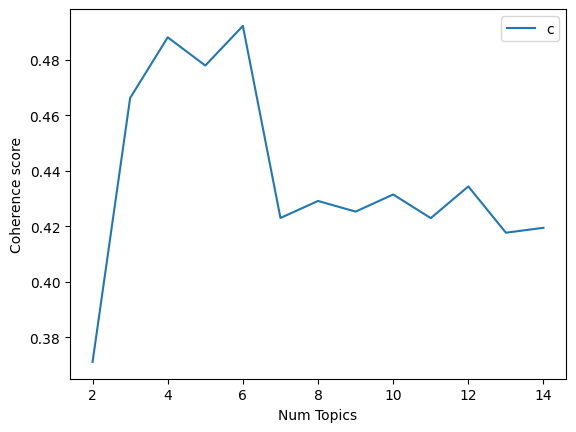

Num Topics = 2  has Coherence Value of 0.3711
Num Topics = 3  has Coherence Value of 0.4663
Num Topics = 4  has Coherence Value of 0.4881
Num Topics = 5  has Coherence Value of 0.478
Num Topics = 6  has Coherence Value of 0.4922
Num Topics = 7  has Coherence Value of 0.423
Num Topics = 8  has Coherence Value of 0.4291
Num Topics = 9  has Coherence Value of 0.4253
Num Topics = 10  has Coherence Value of 0.4315
Num Topics = 11  has Coherence Value of 0.423
Num Topics = 12  has Coherence Value of 0.4344
Num Topics = 13  has Coherence Value of 0.4177
Num Topics = 14  has Coherence Value of 0.4195


In [6]:
# Prepare data
texts = df.apply(word_tokenize)
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(rev) for rev in texts]
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=texts, start=2, end=15, step=1)

#Visualize
x = range(2, len(coherence_values) + 2)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

+ Based on coherence score, chose the optimal parameter

In [16]:
# Modeling
n_topics = 7
lsa_model = TruncatedSVD(n_components=n_topics, algorithm='randomized', n_iter=10, random_state=42)
lsa_top=lsa_model.fit_transform(vect_text)

In [17]:
# from sklearn.decomposition import LatentDirichletAllocation
# n_topics = 8
# lsa_model=LatentDirichletAllocation(n_components=n_topics,learning_method='online',random_state=42,max_iter=1) 
# lsa_top=lsa_model.fit_transform(vect_text)

# Model validation

In [18]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

keys = get_keys(lsa_top)
pd.Series(keys).value_counts()

0    41642
1     3480
4     1288
2      988
5      932
6      855
3      815
Name: count, dtype: int64

+ Using tnse or pca to visual

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.157s...
[t-SNE] Computed neighbors for 50000 samples in 13.338s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for s

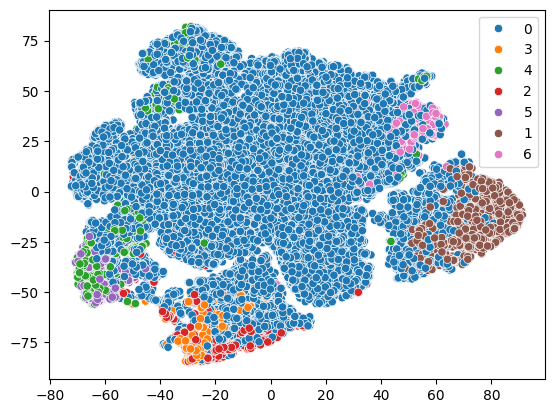

In [19]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                    n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_vectors = tsne_model.fit_transform(lsa_top)    

# colormap = np.array([
#     "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
#     "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
#     "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
#     "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])

colormap = np.array([str(i) for i in range(20)])
colormap = colormap[:n_topics]
plt.figure()
sns.scatterplot(x=tsne_vectors[:,0], y=tsne_vectors[:,1],hue=colormap[keys] )
plt.show()

+ Visual key word in each topic

In [20]:
# most important words for each topic
vocab = vect.get_feature_names_out()

for i, comp in enumerate(lsa_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
like coffee taste flavor product good would food great love 

Topic 1: 
coffee strong roast blend bold kcups pod weak keurig bitter 

Topic 2: 
food coffee product dog treat cat amazon price time year 

Topic 3: 
food like cat treat dog flavor chicken ingredient taste smell 

Topic 4: 
treat love chip flavor dog chocolate great cooky snack chew 

Topic 5: 
treat dog like product taste water smell drink chew bottle 

Topic 6: 
flavor water product drink sauce bottle green great favorite tried 



In [21]:
# df = pd.concat([df,pd.Series(keys)],axis = 1)
# df = pd.concat([df,df_sampled[['Summary']].iloc[:]],axis = 1)

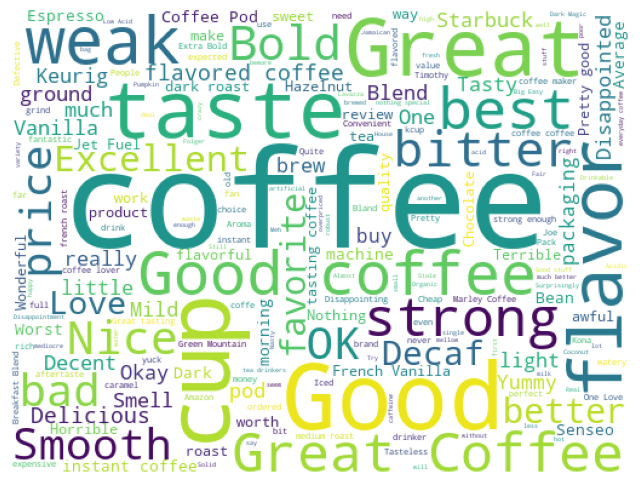

In [14]:
label = 1

df1 = df[df.iloc[:,1]==label]['Summary']
plt.subplots(figsize=(8,8))
wordcloud = WordCloud(background_color='white', width=512, height=384).generate(" ".join(df1))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

TypeError: sequence item 9493: expected str instance, float found

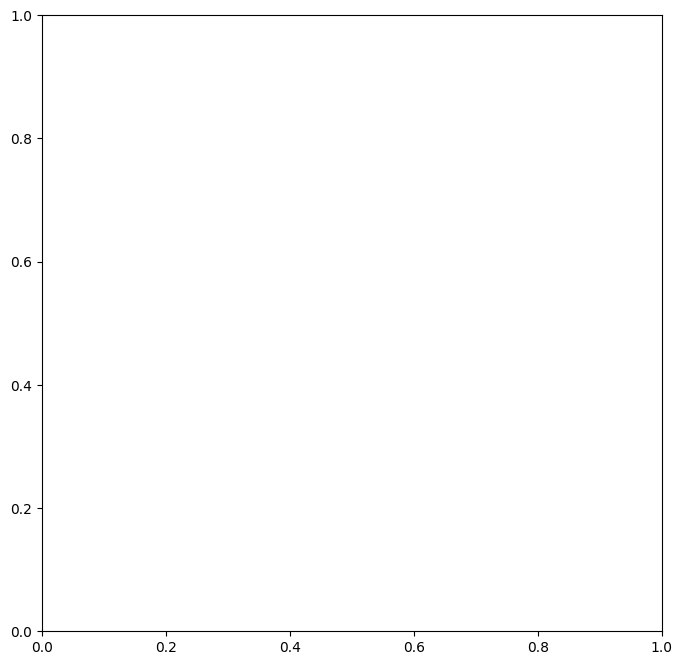

In [15]:
label = 0

df1 = df[df.iloc[:,1]==label]['Summary']
plt.subplots(figsize=(8,8))
wordcloud = WordCloud(background_color='white', width=512, height=384).generate(" ".join(df1))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()